In [1]:
pip install astropy scipy matplotlib numpy h5py tqdm numba pint-pulsar emcee corner statsmodels pyfftw tbb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytest pytest-astropy jinja2 docutils sphinx-astropy nbsphinx pandoc ipython jupyter notebook towncrier tox black

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stingray PyROA emcee tabulate corner astropy

Note: you may need to restart the kernel to use updated packages.


In [4]:
%cd /home/jovyan/AS4013/PYCCF

/home/jovyan/AS4013/PYCCF


In [5]:
import shutil

# Replace '/path/to/work_directory' with your actual work directory
work_directory = '/home/jovyan/AS4013'

# Copy xcorspc.so and PYCCF.py to the work directory
shutil.copy('xcorspc.pyx', work_directory)
shutil.copy('PYCCF.py', work_directory)

'/home/jovyan/AS4013/PYCCF.py'

In [6]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum
import sys
import argparse
import PYCCF as myccf
import random
from scipy import stats 
import os
import PyROA
import matplotlib.pyplot as plt
import psi
from scipy.integrate import simps

import importlib
importlib.reload(psi)

/opt/conda/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


<module 'psi' from '/home/jovyan/AS4013/psi.py'>

In [7]:
#import flux and time here 
#make sure to changes time to days 
#time = np.array(column1_data)/(24*3600)
#flux = np.array(column2_data)

directory_path = '/home/jovyan/AS4013'
file_name = 'lc30mins.dat'
file_path = os.path.join(directory_path, file_name)

column_index1 = 0  
column_index2 = 1

with open(file_path, 'r') as file:
    # Read all lines
    lines = file.readlines()
    data_lines = lines[1:]
    
   # Extract the desired columns from each line and convert to float
    column1_data = [float(line.split()[column_index1]) for line in data_lines]
    column2_data = [float(line.split()[column_index2]) for line in data_lines]

time = np.array(column1_data)/(24*3600)
flux = np.array(column2_data)

In [8]:
#########################################
##Set Interpolation settings, user-specified
#########################################
lag_range = [-100, 100]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 0.2 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 100  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.
#########################################
##Set freq-lag settings, user-specified
#########################################
window = 1  #width of window function PYROA 
cs_binning = 100 #averaged cross spectrum binning 
error_in_flux = 0.01 #define percentage error in flux 
SN = 100 #sound to noise ratio 
sampling_rate = 1 #how many samples are taken per day 
sampling_loss = 0.2 # the amount of data lost due to sampling issues
final_length = 350 #length of final array in days 
dt = 1800 #each interval in seconds 
S = 1.0 #sd of BLR function
M = np.log(13.9) # mean of BLR function


exposure = len(time) #length of full array 
seconds_day = 86400
original_length = exposure/(seconds_day/dt)

times = (np.linspace(-exposure, exposure+1, num = exposure*2)*dt)/(24*3600) # converted to days

def disk(times,wavelength,A1):#define a response function for the accretion disk  
    bhmass = 10**7.22       # Msol
    mdot = 0.708         # Msol/yr
    inc = 58           # inclination, degrees
    combi_psi = psi.pytfb_sub(times,1e8,mdot,wavelength,inc,norm=1)
    combi_psi[np.isnan(combi_psi)]=0
    # normalise 
    normi = simps(combi_psi,x=times)
    return A1*(combi_psi/normi)
 

# Define BLR response function
def BLR(times,A2): 
    #log normal distribution
    BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
    BLR_array[np.isnan(BLR_array)]=0
    return  BLR_array

In [9]:
#define them by wavelenth and BLR fraction
BLR_array_1 = BLR(times, 0.5) 
combi_psi_1 = disk(times, 4770, (0.5))

#mixture model 
BLR_array = BLR_array_1 + combi_psi_1

### Perform convolution
signal4_BLR = np.convolve(flux, BLR_array, mode='full')
start_index = int((len(signal4_BLR) - len(flux)) / 2)
end_index = start_index + len(flux)
#index as we used a full convolution
signal4_BLR = signal4_BLR[start_index:end_index]

#create the array to be only over area of interest
interval = (original_length-final_length)/2
start = int(seconds_day/dt*interval)
end = int(seconds_day/dt*(original_length-interval))


/tmp/ipykernel_2298/4132634249.py:44: RuntimeWarning: invalid value encountered in sqrt
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
/tmp/ipykernel_2298/4132634249.py:44: RuntimeWarning: invalid value encountered in log
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))


### Create Light curves and response functions 

In [10]:
signal4_BLR = signal4_BLR[start:end]
flux = flux[start:end]
time = time[start:end]

new_times = []
new_flux_BLR = []
new_flux_lc = []

#sample randomly
for i in range(final_length):
    
    random_number = random.randint(0, seconds_day/dt)
    index = int(i*seconds_day/dt) + random_number
    
    new_times.append(time[index])
    new_flux_lc.append(flux[index])
    new_flux_BLR.append(signal4_BLR[index])


lost_data = int(len(new_flux_lc)*sampling_loss)  

#remove lost data
for i in range(lost_data):
    
    random_number = random.randint(0,len(new_times)-1)
    new_flux_lc.pop(random_number)
    new_times.pop(random_number)
    new_flux_BLR.pop(random_number)

#create lightcurves
lc_BLR = Lightcurve(new_times,new_flux_BLR )
lc = Lightcurve(new_times,new_flux_lc)

lc_test_BLR =Lightcurve(time,signal4_BLR)
lc_test = Lightcurve(time,flux)    

#getting mean 
mean_lc_BLR = np.mean(lc_BLR.counts)
mean_lc = np.mean(lc.counts)
mean_lc_test_BLR = np.mean(lc_test_BLR.counts)
mean_lc_test = np.mean(lc_test.counts)

#getting standard deviation
sd_lc_BLR = np.std(lc_BLR.counts)
sd_lc = np.std(lc.counts)
sd_lc_test_BLR = np.std(lc_test_BLR.counts)
sd_lc_test = np.std(lc_test.counts)

#normalising
lc_BLR_N = (lc_BLR.counts-mean_lc_BLR)/sd_lc_BLR
lc_N = (lc.counts-mean_lc)/sd_lc
lc_test_BLR_N = (lc_test_BLR.counts-mean_lc_test_BLR)/sd_lc_test_BLR
lc_test_N = (lc_test.counts-mean_lc_test)/sd_lc_test

# and adding noise
lc_test_BLR_N = np.random.normal(lc_test_BLR_N,abs(lc_test_BLR_N/SN))
lc_test_N = np.random.normal(lc_test_N,abs(lc_test_N/SN))

#create normalised lightcurves
lc_test_BLR_N = Lightcurve(lc_test_BLR.time,lc_test_BLR_N)
lc_test_N = Lightcurve(lc_test.time,lc_test_N)

#create errors in flux 
lc_test_N.counts_err = abs(lc_test_N.counts*error_in_flux)
lc_test_BLR_N.counts_err = abs(lc_test_BLR_N.counts*error_in_flux)

#average cross spectrum 
avg_cs_BLR = AveragedCrossspectrum.from_lightcurve(lc_test_BLR_N, lc_test_N, cs_binning)

#logarithmically rebin 
log_rb_cs = avg_cs_BLR.rebin_log(f=1.2)

#define time lags 
freq_lags, freq_lags_err = log_rb_cs.time_lag()

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 460.90it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/conda

### add noise, add error then interpolate with PYROA and find cross spectrum and frequency resolved lags for each value of noise 

In [11]:
SN = 100
lc_BLR_N_1 = np.random.normal(lc_BLR_N, abs(lc_BLR_N/SN))
lc_N_1 = np.random.normal(lc_N, abs(lc_N/SN))
lc_BLR_N_1 = Lightcurve(lc_BLR.time, lc_BLR_N_1)
lc_N_1 = Lightcurve(lc.time, lc_N_1)
lc_N_1.counts_err = abs(lc_N_1.counts*error_in_flux)
lc_BLR_N_1.counts_err = abs(lc_BLR_N_1.counts*error_in_flux)
(lc_P_times_1, lc_P_counts_1, lc_P_err_1) = PyROA.RunningOptimalAverage(lc_N_1.time, lc_N_1.counts, lc_N_1.counts_err, window)
(lc_BLR_P_times_1, lc_BLR_P_counts_1, lc_BLR_P_err_1) = PyROA.RunningOptimalAverage(lc_BLR_N_1.time, lc_BLR_N_1.counts, lc_BLR_N_1.counts_err, window)
lcp_1 = Lightcurve(lc_P_times_1, lc_P_counts_1, err=lc_P_err_1)
lcBLRp_1 = Lightcurve(lc_BLR_P_times_1, lc_BLR_P_counts_1, err=lc_BLR_P_err_1)
avg_cs_BLR_P_1 = AveragedCrossspectrum.from_lightcurve(lcBLRp_1, lcp_1, cs_binning)
log_rb_cs_P_1 = avg_cs_BLR_P_1.rebin_log(f=1.2)

freq_lags_P_1, freq_lags_err_P_1 = log_rb_cs_P_1.time_lag()


/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 954.05it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/conda

In [12]:
SN = 5
lc_BLR_N_20 = np.random.normal(lc_BLR_N, abs(lc_BLR_N/SN))
lc_N_20 = np.random.normal(lc_N, abs(lc_N/SN))
lc_BLR_N_20 = Lightcurve(lc_BLR.time, lc_BLR_N_20)
lc_N_20 = Lightcurve(lc.time, lc_N_20)
lc_N_20.counts_err = abs(lc_N_20.counts*error_in_flux)
lc_BLR_N_20.counts_err = abs(lc_BLR_N_20.counts*error_in_flux)
(lc_P_times_20, lc_P_counts_20, lc_P_err_20) = PyROA.RunningOptimalAverage(lc_N_20.time, lc_N_20.counts, lc_N_20.counts_err, window)
(lc_BLR_P_times_20, lc_BLR_P_counts_20, lc_BLR_P_err_20) = PyROA.RunningOptimalAverage(lc_BLR_N_20.time, lc_BLR_N_20.counts, lc_BLR_N_20.counts_err, window)
lcp_20 = Lightcurve(lc_P_times_20, lc_P_counts_20, err=lc_P_err_20)
lcBLRp_20 = Lightcurve(lc_BLR_P_times_20, lc_BLR_P_counts_20, err=lc_BLR_P_err_20)
avg_cs_BLR_P_20 = AveragedCrossspectrum.from_lightcurve(lcBLRp_20, lcp_20, cs_binning)
log_rb_cs_P_20 = avg_cs_BLR_P_20.rebin_log(f=1.2)

freq_lags_P_20, freq_lags_err_P_20 = log_rb_cs_P_20.time_lag()

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 1761.08it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/cond

In [13]:
SN = 10
lc_BLR_N_10 = np.random.normal(lc_BLR_N, abs(lc_BLR_N/SN))
lc_N_10 = np.random.normal(lc_N, abs(lc_N/SN))
lc_BLR_N_10 = Lightcurve(lc_BLR.time, lc_BLR_N_10)
lc_N_10 = Lightcurve(lc.time, lc_N_10)
lc_N_10.counts_err = abs(lc_N_10.counts*error_in_flux)
lc_BLR_N_10.counts_err = abs(lc_BLR_N_10.counts*error_in_flux)
(lc_P_times_10, lc_P_counts_10, lc_P_err_10) = PyROA.RunningOptimalAverage(lc_N_10.time, lc_N_10.counts, lc_N_10.counts_err, window)
(lc_BLR_P_times_10, lc_BLR_P_counts_10, lc_BLR_P_err_10) = PyROA.RunningOptimalAverage(lc_BLR_N_10.time, lc_BLR_N_10.counts, lc_BLR_N_10.counts_err, window)
lcp_10 = Lightcurve(lc_P_times_10, lc_P_counts_10, err=lc_P_err_10)
lcBLRp_10 = Lightcurve(lc_BLR_P_times_10, lc_BLR_P_counts_10, err=lc_BLR_P_err_10)
avg_cs_BLR_P_10 = AveragedCrossspectrum.from_lightcurve(lcBLRp_10, lcp_10, cs_binning)
log_rb_cs_P_10 = avg_cs_BLR_P_10.rebin_log(f=1.2)

freq_lags_P_10, freq_lags_err_P_10 = log_rb_cs_P_10.time_lag()

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 1774.24it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/cond

In [14]:
SN = 20
lc_BLR_N_5 = np.random.normal(lc_BLR_N, abs(lc_BLR_N/SN))
lc_N_5 = np.random.normal(lc_N, abs(lc_N/SN))
lc_BLR_N_5 = Lightcurve(lc_BLR.time, lc_BLR_N_5)
lc_N_5 = Lightcurve(lc.time, lc_N_5)
lc_N_5.counts_err = abs(lc_N_5.counts*error_in_flux)
lc_BLR_N_5.counts_err = abs(lc_BLR_N_5.counts*error_in_flux)
(lc_P_times_5, lc_P_counts_5, lc_P_err_5) = PyROA.RunningOptimalAverage(lc_N_5.time, lc_N_5.counts, lc_N_5.counts_err, window)
(lc_BLR_P_times_5, lc_BLR_P_counts_5, lc_BLR_P_err_5) = PyROA.RunningOptimalAverage(lc_BLR_N_5.time, lc_BLR_N_5.counts, lc_BLR_N_5.counts_err, window)
lcp_5 = Lightcurve(lc_P_times_5, lc_P_counts_5, err=lc_P_err_5)
lcBLRp_5 = Lightcurve(lc_BLR_P_times_5, lc_BLR_P_counts_5, err=lc_BLR_P_err_5)
avg_cs_BLR_P_5 = AveragedCrossspectrum.from_lightcurve(lcBLRp_5, lcp_5, cs_binning)
log_rb_cs_P_5 = avg_cs_BLR_P_5.rebin_log(f=1.2)

freq_lags_P_5, freq_lags_err_P_5 = log_rb_cs_P_5.time_lag()

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 1481.56it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/cond

In [15]:
SN = 3.3
lc_BLR_N_30 = np.random.normal(lc_BLR_N, abs(lc_BLR_N/SN))
lc_N_30 = np.random.normal(lc_N, abs(lc_N/SN))
lc_BLR_N_30 = Lightcurve(lc_BLR.time, lc_BLR_N_30)
lc_N_30 = Lightcurve(lc.time, lc_N_30)
lc_N_30.counts_err = abs(lc_N_30.counts*error_in_flux)
lc_BLR_N_30.counts_err = abs(lc_BLR_N_30.counts*error_in_flux)
(lc_P_times_30, lc_P_counts_30, lc_P_err_30) = PyROA.RunningOptimalAverage(lc_N_30.time, lc_N_30.counts, lc_N_30.counts_err, window)
(lc_BLR_P_times_30, lc_BLR_P_counts_30, lc_BLR_P_err_30) = PyROA.RunningOptimalAverage(lc_BLR_N_30.time, lc_BLR_N_30.counts, lc_BLR_N_30.counts_err, window)
lcp_30 = Lightcurve(lc_P_times_30, lc_P_counts_30, err=lc_P_err_30)
lcBLRp_30 = Lightcurve(lc_BLR_P_times_30, lc_BLR_P_counts_30, err=lc_BLR_P_err_30)
avg_cs_BLR_P_30 = AveragedCrossspectrum.from_lightcurve(lcBLRp_30, lcp_30, cs_binning)
log_rb_cs_P_30 = avg_cs_BLR_P_30.rebin_log(f=1.2)

freq_lags_P_30, freq_lags_err_P_30 = log_rb_cs_P_30.time_lag()

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 1489.28it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/cond

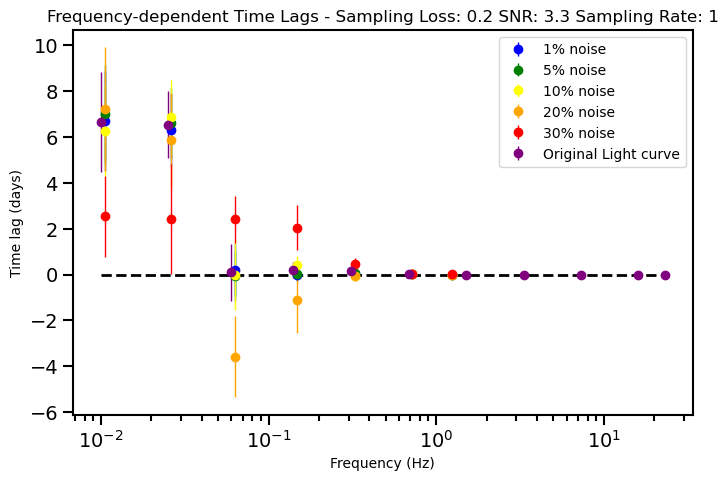

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hlines(0, log_rb_cs.freq[0], log_rb_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(log_rb_cs_P_1.freq+0.05*log_rb_cs_P_1.freq, freq_lags_P_1, yerr=freq_lags_err_P_1,fmt="o", lw=1, color='blue', label='1% noise')
ax.errorbar(log_rb_cs_P_5.freq+0.05*log_rb_cs_P_5.freq, freq_lags_P_5, yerr=freq_lags_err_P_5,fmt="o", lw=1, color='green', label='5% noise')
ax.errorbar(log_rb_cs_P_10.freq+0.05*log_rb_cs_P_10.freq, freq_lags_P_10, yerr=freq_lags_err_P_10,fmt="o", lw=1, color='yellow', label='10% noise')
ax.errorbar(log_rb_cs_P_20.freq+0.05*log_rb_cs_P_20.freq, freq_lags_P_20, yerr=freq_lags_err_P_20,fmt="o", lw=1, color='orange', label='20% noise')
ax.errorbar(log_rb_cs_P_30.freq+0.05*log_rb_cs_P_30.freq, freq_lags_P_30, yerr=freq_lags_err_P_30,fmt="o", lw=1, color='red', label='30% noise')
ax.errorbar(log_rb_cs.freq, freq_lags, yerr=freq_lags_err, fmt="o", lw=1, color='purple', label='Original Light curve')
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Time lag (days)")
ax.set_title("Frequency-dependent Time Lags - Sampling Loss: {} SNR: {} Sampling Rate: {}".format(sampling_loss, SN, sampling_rate))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.semilogx()
plt.legend()
# Include noise value in the filename
#filename = os.path.join('PYROA_test_FreqLag_dataloss(%)_{}_SN{}_samplingrate(per day){}.png'.format(sampling_loss, SN, sampling_rate))
#plt.savefig(filename,format = 'png', orientation = 'landscape', bbox_inches = 'tight')

plt.show()

## Plot differences in frequency resolved lags for visualisation

In [17]:
diff_1 = []
diff_5 = []
diff_10 = []
diff_20 = []
diff_30 = []
zeros = []

for i in range(len(freq_lags_P_1)):
    diff_1.append(np.abs(freq_lags_P_1[i] - freq_lags[i])/ freq_lags_err[i]) 
    diff_5.append(np.abs(freq_lags_P_5[i] - freq_lags[i])/ freq_lags_err[i]) 
    diff_10.append(np.abs(freq_lags_P_10[i] - freq_lags[i])/ freq_lags_err[i]) 
    diff_20.append(np.abs(freq_lags_P_20[i] - freq_lags[i])/ freq_lags_err[i]) 
    diff_30.append(np.abs(freq_lags_P_30[i] - freq_lags[i])/ freq_lags_err[i]) 

for i in range(len(freq_lags)):
    zeros.append(0)
    

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hlines(0, log_rb_cs.freq[0], log_rb_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.scatter(log_rb_cs_P_1.freq, diff_1,  color='blue', label='1% noise')
ax.scatter(log_rb_cs_P_5.freq, diff_5,  color='green', label='5% noise')
ax.scatter(log_rb_cs_P_10.freq, diff_10,  color='yellow', label='10% noise')
ax.scatter(log_rb_cs_P_20.freq, diff_20,  color='orange', label='20% noise')
ax.scatter(log_rb_cs_P_30.freq, diff_30, color='red', label='30% noise')
ax.errorbar(log_rb_cs.freq, zeros, yerr=[zeros,freq_lags_err], fmt="o", lw=1, color='purple',label='Original Light curve with error bars',alpha = 0.4, )
ax.set_xlabel("Frequency (1/day)", fontsize=15)
ax.set_ylabel("days", fontsize=15)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.semilogx()
plt.legend()
# Include noise value in the filename
#filename = os.path.join('PYROA_test_FreqLag_dataloss(%)_{}_SN{}_samplingrate(per day){}.png'.format(sampling_loss, SN, sampling_rate))
#plt.savefig(filename,format = 'png', orientation = 'landscape', bbox_inches = 'tight')
plt.subplots_adjust(top=1, bottom=0.15)
plt.savefig('/home/jovyan/AS4013/testingPYROAnoise.png')
plt.show()